In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fetch data
btc_data = yf.download('BTC-USD', start='2015-01-01', end=datetime.now().strftime('%Y-%m-%d'))
eth_data = yf.download('ETH-USD', start='2015-01-01', end=datetime.now().strftime('%Y-%m-%d'))

btc_data.index = pd.to_datetime(btc_data.index)
eth_data.index = pd.to_datetime(eth_data.index)

# Adding Ethereum closing prices to the Bitcoin dataframe
btc_data['ETH_Price'] = eth_data['Close']

# Feature engineering
btc_data['Rolling_Mean_7'] = btc_data['Close'].rolling(window=7).mean().fillna(method='bfill')
btc_data['Rolling_Std_7'] = btc_data['Close'].rolling(window=7).std().fillna(method='bfill')

# Remove any rows with NaN values to ensure data integrity
btc_data.dropna(inplace=True)

# Normalize data
scaler = MinMaxScaler()
features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'Rolling_Mean_7', 'Rolling_Std_7', 'ETH_Price']
btc_data[features_to_scale] = scaler.fit_transform(btc_data[features_to_scale])

# Prepare data for LSTM input
def create_sequences(data, time_steps=7):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data.iloc[i-time_steps:i][features_to_scale].values)
        y.append(data.iloc[i][['High', 'Low', 'Close']].values)
    return np.array(X), np.array(y)

X, y = create_sequences(btc_data)

# Define the LSTM model with gradient clipping
model = Sequential([
    LSTM(128, input_shape=(7, len(features_to_scale)), return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.3),
    Dense(3)
])
optimizer = Adam(lr=0.001, clipvalue=0.5)  # Adding gradient clipping
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
train_size = int(0.9 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
# Function to predict future prices
def predict_and_trade(start_date):
    # Check if the start date is within the dataset
    if pd.to_datetime(start_date) not in btc_data.index:
        print(f"Start date {start_date} is beyond the available data. Using the last available data for predictions.")
        start_date = btc_data.index[-1]
    idx = btc_data.index.get_loc(start_date)
    last_sequences = btc_data.iloc[idx-7:idx][features_to_scale].values.reshape(1, 7, len(features_to_scale))
    predictions = model.predict(last_sequences)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], len(features_to_scale) - 3)))))[:, :3]

    # Get the highest and lowest prices for each day for the next 7 days
    highest_prices = [price[0] for price in predictions]  # High prices
    lowest_prices = [price[1] for price in predictions]  # Low prices

    return highest_prices, lowest_prices

# Example prediction
start_date = '2024-05-19'
highest_prices, lowest_prices = predict_and_trade(start_date)
print(f"Highest prices for the next 7 days from {start_date} are:")
for i in range(7):
    print(f"Day {i+1}: {highest_prices[i]}")
print("\nLowest prices for the next 7 days from {start_date} are:")
for i in range(7):
    print(f"Day {i+1}: {lowest_prices[i]}")


# # Example prediction and trading
# start_date = '2024-05-19'
# predicted_prices, final_cash = predict_and_trade(start_date)
# print(f"Predicted High, Low, and Closing Prices for the next 7 days from {start_date} are:", predicted_prices)
# print(f"Final cash after trading based on predictions: ${final_cash:,.2f}")
# Calculate and print RMSE
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print("Root Mean Squared Error:", rmse)

# Calculate and print MAPE
mape = np.mean(np.abs((y_test - model.predict(X_test)) / y_test)) * 100
print("Mean Absolute Percentage Error:", mape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
67/67 [==============================] - 3s 5ms/step - loss: 0.0108
Epoch 2/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 3/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 4/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 5/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 6/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 7/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 8/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 9/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 10/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 11/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 12/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 13/50
67/67 [==============================

IndexError: list index out of range

In [ ]:
print(highest_prices)

[68838.77901609123]


In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fetch data for Bitcoin and other financial indicators
btc_data = yf.download('BTC-USD', start='2015-01-01', end=datetime.now().strftime('%Y-%m-%d'))
eth_data = yf.download('ETH-USD', start='2015-01-01', end=datetime.now().strftime('%Y-%m-%d'))

# Set datetime index
btc_data.index = pd.to_datetime(btc_data.index)
eth_data.index = pd.to_datetime(eth_data.index)

# Adding Ethereum closing prices to the Bitcoin dataframe
btc_data['ETH_Price'] = eth_data['Close'].reindex(btc_data.index, method='nearest')  # Use 'nearest' to avoid NaNs

# Feature engineering
btc_data['Rolling_Mean_7'] = btc_data['Close'].rolling(window=7).mean().fillna(method='bfill')
btc_data['Rolling_Std_7'] = btc_data['Close'].rolling(window=7).std().fillna(method='bfill')

# Normalize data
scaler = MinMaxScaler()
features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'Rolling_Mean_7', 'Rolling_Std_7', 'ETH_Price']
btc_data[features_to_scale] = scaler.fit_transform(btc_data[features_to_scale])

# Prepare data for LSTM input
def create_sequences(data, time_steps=7):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data.iloc[i-time_steps:i][features_to_scale].values)
        y.append(data.iloc[i][['High', 'Low', 'Close']].values)
    return np.array(X), np.array(y)

X, y = create_sequences(btc_data)

# Define the LSTM model with gradient clipping
model = Sequential([
    LSTM(128, input_shape=(7, len(features_to_scale)), return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.3),
    Dense(3)  # Outputs: High, Low, Close
])
optimizer = Adam(lr=0.001, clipvalue=0.5)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
train_size = int(0.9 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
# Example prediction and trading
start_date = '2024-05-18'
predicted_prices, final_cash = predict_and_trade(start_date)
print(f"Predicted High, Low, and Closing Prices for the next 7 days from {start_date} are:", predicted_prices)
print(f"Final cash after trading based on predictions: ${final_cash:,.2f}")
# Calculate and print RMSE
# Evaluate the model using RMSE and MAPE
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
97/97 [==============================] - 3s 5ms/step - loss: 0.0044
Epoch 2/50
97/97 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 3/50
97/97 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 4/50
97/97 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 5/50
97/97 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 6/50
97/97 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 7/50
97/97 [==============================] - 0s 5ms/step - loss: 9.8240e-04
Epoch 8/50
97/97 [==============================] - 0s 5ms/step - loss: 9.3271e-04
Epoch 9/50
97/97 [==============================] - 1s 5ms/step - loss: 9.2697e-04
Epoch 10/50
97/97 [==============================] - 1s 5ms/step - loss: 8.3086e-04
Epoch 11/50
97/97 [==============================] - 0s 5ms/step - loss: 8.2007e-04
Epoch 12/50
97/97 [==============================] - 0s 5ms/step - loss: 7.6466e-04
Epoch 13/50
97/97 [======

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fetch data
btc_data = yf.download('BTC-USD', start='2015-01-01', end=datetime.now().strftime('%Y-%m-%d'))
eth_data = yf.download('ETH-USD', start='2015-01-01', end=datetime.now().strftime('%Y-%m-%d'))

btc_data.index = pd.to_datetime(btc_data.index)
eth_data.index = pd.to_datetime(eth_data.index)

# Adding Ethereum closing prices to the Bitcoin dataframe
btc_data['ETH_Price'] = eth_data['Close']

# Feature engineering
btc_data['Rolling_Mean_7'] = btc_data['Close'].rolling(window=7).mean().fillna(method='bfill')
btc_data['Rolling_Std_7'] = btc_data['Close'].rolling(window=7).std().fillna(method='bfill')

# Remove any rows with NaN values to ensure data integrity
btc_data.dropna(inplace=True)

# Normalize data
scaler = MinMaxScaler()
features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'Rolling_Mean_7', 'Rolling_Std_7', 'ETH_Price']
btc_data[features_to_scale] = scaler.fit_transform(btc_data[features_to_scale])

# Prepare data for LSTM input
def create_sequences(data, time_steps=7):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data.iloc[i-time_steps:i][features_to_scale].values)
        y.append(data.iloc[i][['High', 'Low', 'Close']].values)
    return np.array(X), np.array(y)

X, y = create_sequences(btc_data)

# Define the LSTM model with gradient clipping
model = Sequential([
    LSTM(128, input_shape=(7, len(features_to_scale)), return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.3),
    Dense(3)
])
optimizer = Adam(lr=0.001, clipvalue=0.5)  # Adding gradient clipping
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
train_size = int(0.9 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Function to predict future prices
def predict_and_trade(start_date):
    # Check if the start date is within the dataset
    if pd.to_datetime(start_date) not in btc_data.index:
        print(f"Start date {start_date} is beyond the available data. Using the last available data for predictions.")
        start_date = btc_data.index[-1]
    idx = btc_data.index.get_loc(start_date)
    last_sequences = btc_data.iloc[idx-7:idx][features_to_scale].values.reshape(1, 7, len(features_to_scale))
    predictions = model.predict(last_sequences)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], len(features_to_scale) - 3)))))[:, :3]

    # Get the highest and lowest prices for each day for the next 7 days
    highest_prices = [predictions[0][0] + (i+1) * (predictions[0][0] - predictions[0][1]) for i in range(7)]  # High prices
    lowest_prices = [predictions[0][1] + (i+1) * (predictions[0][0] - predictions[0][1]) for i in range(7)]  # Low prices

    return highest_prices, lowest_prices

# Example prediction
start_date = '2024-05-19'
highest_prices, lowest_prices = predict_and_trade(start_date)
print(f"Highest prices for the next 7 days from {start_date} are:")
for i in range(7):
    print(f"Day {i+1}: {highest_prices[i]}")
print("\nLowest prices for the next 7 days from {start_date} are:")
for i in range(7):
    print(f"Day {i+1}: {lowest_prices[i]}")

# Calculate and print RMSE
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print("Root Mean Squared Error:", rmse)

# Calculate and print MAPE
mape = np.mean(np.abs((y_test - model.predict(X_test)) / y_test)) * 100
print("Mean Absolute Percentage Error:", mape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
67/67 [==============================] - 3s 5ms/step - loss: 0.0079
Epoch 2/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 3/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 4/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 5/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 6/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 7/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 8/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 9/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 10/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 11/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 12/50
67/67 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 13/50
67/67 [==============================

In [ ]:
start_date = '2024-05-18'
highest_prices, lowest_prices = predict_and_trade(start_date)
print(f"Highest prices for the next 7 days from {start_date} are:")
for i in range(7):
    print(f"Day {i+1}: {highest_prices[i]}")
print("\nLowest prices for the next 7 days from {start_date} are:")
for i in range(7):
    print(f"Day {i+1}: {lowest_prices[i]}")

# Calculate and print RMSE
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print("Root Mean Squared Error:", rmse)

# Calculate and print MAPE
mape = np.mean(np.abs((y_test - model.predict(X_test)) / y_test)) * 100
print("Mean Absolute Percentage Error:", mape)

Start date 2024-05-18 is beyond the available data. Using the last available data for predictions.
1/1 [==============================] - 0s 18ms/step
Highest prices for the next 7 days from 2024-05-18 are:
Day 1: 67477.3444398019
Day 2: 67993.58145224724
Day 3: 68509.81846469257
Day 4: 69026.0554771379
Day 5: 69542.29248958323
Day 6: 70058.52950202856
Day 7: 70574.76651447389

Lowest prices for the next 7 days from {start_date} are:
Day 1: 66961.10742735658
Day 2: 67477.3444398019
Day 3: 67993.58145224724
Day 4: 68509.81846469257
Day 5: 69026.0554771379
Day 6: 69542.29248958323
Day 7: 70058.52950202856
8/8 [==============================] - 0s 2ms/step
Root Mean Squared Error: 0.023166622472110366
8/8 [==============================] - 0s 2ms/step
Mean Absolute Percentage Error: 3.000793739549881


In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fetch data for Bitcoin and other financial indicators
btc_data = yf.download('BTC-USD', start='2015-01-01', end=datetime.now().strftime('%Y-%m-%d'))
eth_data = yf.download('ETH-USD', start='2015-01-01', end=datetime.now().strftime('%Y-%m-%d'))

# Set datetime index
btc_data.index = pd.to_datetime(btc_data.index)
eth_data.index = pd.to_datetime(eth_data.index)

# Adding Ethereum closing prices to the Bitcoin dataframe
btc_data['ETH_Price'] = eth_data['Close'].reindex(btc_data.index, method='nearest')  # Use 'nearest' to avoid NaNs

# Feature engineering
btc_data['Rolling_Mean_7'] = btc_data['Close'].rolling(window=7).mean().fillna(method='bfill')
btc_data['Rolling_Std_7'] = btc_data['Close'].rolling(window=7).std().fillna(method='bfill')

# Normalize data
scaler = MinMaxScaler()
features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'Rolling_Mean_7', 'Rolling_Std_7', 'ETH_Price']
btc_data[features_to_scale] = scaler.fit_transform(btc_data[features_to_scale])

# Prepare data for LSTM input
def create_sequences(data, time_steps=7):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data.iloc[i-time_steps:i][features_to_scale].values)
        y.append(data.iloc[i][['High', 'Low', 'Close']].values)
    return np.array(X), np.array(y)

X, y = create_sequences(btc_data)

# Define the LSTM model with gradient clipping
model = Sequential([
    LSTM(128, input_shape=(7, len(features_to_scale)), return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.3),
    Dense(3)  # Outputs: High, Low, Close
])
optimizer = Adam(lr=0.001, clipvalue=0.5)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
train_size = int(0.9 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Predict prices for the next 7 days
def predict_prices(start_date):
    # Convert the start date to datetime object
    start_date = pd.to_datetime(start_date)

    # Get the last available data point
    last_data = btc_data.iloc[-1]

    # Create a sequence of 7 data points for prediction
    input_sequence = btc_data[features_to_scale].iloc[-7:].values.reshape(1, 7, len(features_to_scale))

    # Predict the next 7 days
    predicted_prices = []
    for _ in range(7):
        prediction = model.predict(input_sequence)[0]
        predicted_prices.append(prediction)

        # Update the input sequence with the predicted values
        prediction_reshaped = np.concatenate((prediction, np.zeros(len(features_to_scale) - 3)), axis=0).reshape(1, 1, len(features_to_scale))
        input_sequence = np.concatenate((input_sequence[:, 1:, :], prediction_reshaped), axis=1)

    # Convert predicted prices to DataFrame
    predicted_prices_df = pd.DataFrame(predicted_prices, columns=['High', 'Low', 'Close'])
    predicted_prices_df.index = pd.date_range(start=start_date, periods=7, freq='D')

    # Inverse transform the normalized prices
    predicted_prices_df = pd.DataFrame(scaler.inverse_transform(predicted_prices_df),
                                       index=predicted_prices_df.index,
                                       columns=['High', 'Low', 'Close'])

    return predicted_prices_df

# Example prediction
start_date = '2024-05-18'
predicted_prices = predict_prices(start_date)
print(f"Predicted High, Low, and Closing Prices for the next 7 days from {start_date} are:")
print(predicted_prices)

# Calculate and print RMSE and MAPE
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("\nRoot Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
97/97 [==============================] - 3s 5ms/step - loss: 0.0057
Epoch 2/50
97/97 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 3/50
97/97 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 4/50
97/97 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 5/50
97/97 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 6/50
97/97 [==============================] - 0s 5ms/step - loss: 9.7329e-04
Epoch 7/50
97/97 [==============================] - 0s 5ms/step - loss: 9.5936e-04
Epoch 8/50
97/97 [==============================] - 0s 5ms/step - loss: 9.0136e-04
Epoch 9/50
97/97 [==============================] - 0s 5ms/step - loss: 9.4685e-04
Epoch 10/50
97/97 [==============================] - 0s 5ms/step - loss: 9.2856e-04
Epoch 11/50
97/97 [==============================] - 0s 5ms/step - loss: 8.5236e-04
Epoch 12/50
97/97 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 13/50
97/97 [======

ValueError: operands could not be broadcast together with shapes (7,3) (8,) (7,3) 

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1. Data Acquisition and Preprocessing
data = yf.download(tickers='BTC-USD', period='5y')

# Feature Engineering
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['Volatility'] = data['High'] - data['Low']

# Create target variables (highest, lowest, average closing, and dates)
# We shift by -1 instead of -7 because .rolling() includes the current day
data['Highest_Next_7'] = data['High'].shift(-1).rolling(window=7).max()
data['Lowest_Next_7'] = data['Low'].shift(-1).rolling(window=7).min()
data['Avg_Close_Next_7'] = data['Close'].shift(-1).rolling(window=7).mean()
data['Date_Highest_Next_7'] = data['High'].shift(-1).rolling(window=7).apply(
    lambda x: x.idxmax()
)
data['Date_Lowest_Next_7'] = data['Low'].shift(-1).rolling(window=7).apply(
    lambda x: x.idxmin()
)

# Drop rows with NaN values (due to feature calculations and shifts)
data.dropna(inplace=True)

# Split features (X) and target variables (y)
X = data.drop(
    ['Highest_Next_7', 'Lowest_Next_7', 'Avg_Close_Next_7', 'Date_Highest_Next_7', 'Date_Lowest_Next_7'],
    axis=1
)
y = data[['Highest_Next_7', 'Lowest_Next_7', 'Avg_Close_Next_7', 'Date_Highest_Next_7', 'Date_Lowest_Next_7']]

# Split into training and testing sets with TimeSeriesSplit for time-series data
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# 2. Model Selection and Training (Multiple Models)

# Initialize models with hyperparameter grids
models = {
    'RandomForest': (RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [4, 5, 6, 7, 8],
        'criterion': ['squared_error', 'absolute_error']
    }),
    'LinearRegression': (LinearRegression(), {}),
    'SVR': (SVR(), {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    })
}

# Train and evaluate each model
for name, (model, param_grid) in models.items():
    print(f"\nTraining {name} model...")
    grid_search = GridSearchCV(model, param_grid, cv=tscv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)  # Train on all target variables at once
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{name} - Best Parameters:", grid_search.best_params_)
    print(f"{name} - Mean Squared Error:", mse)
    print(f"{name} - Mean Absolute Error:", mae)

    # Plot Actual vs Predicted for the first target variable (example)
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test['Highest_Next_7'], label='Actual')
    plt.plot(y_test.index, y_pred[:, 0], label='Predicted')  # Assuming y_pred is a 2D array
    plt.title(f"{name} - Actual vs Predicted (Highest Price Next 7 Days)")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


[*********************100%%**********************]  1 of 1 completed


TypeError: must be real number, not Timestamp

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1. Data Acquisition and Preprocessing
data = yf.download(tickers='BTC-USD', period='5y')

# Feature Engineering
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['Volatility'] = data['High'] - data['Low']

# Create target variables (highest, lowest, average closing, and dates)
# We shift by -1 instead of -7 because .rolling() includes the current day
data['Highest_Next_7'] = data['High'].shift(-1).rolling(window=7).max()
data['Lowest_Next_7'] = data['Low'].shift(-1).rolling(window=7).min()
data['Avg_Close_Next_7'] = data['Close'].shift(-1).rolling(window=7).mean()


# Calculate index and use to find corresponding date value
def get_date_of_max(x):
    max_value = x.max()
    max_indices = x[x == max_value].index  # Get all indices with max value
    return date_index[max_indices[0]] if not x.empty else pd.NaT  # Return the first date

def get_date_of_min(x):
    min_value = x.min()
    min_indices = x[x == min_value].index  # Get all indices with min value
    return date_index[min_indices[0]] if not x.empty else pd.NaT  # Return the first date


data['Date_Highest_Next_7'] = data['High'].shift(-1).rolling(window=7).apply(get_date_of_max)
data['Date_Lowest_Next_7'] = data['Low'].shift(-1).rolling(window=7).apply(get_date_of_min)

# Drop rows with NaN values (due to feature calculations and shifts)
data.dropna(inplace=True)

# Split features (X) and target variables (y)
X = data.drop(
    ['Highest_Next_7', 'Lowest_Next_7', 'Avg_Close_Next_7', 'Date_Highest_Next_7', 'Date_Lowest_Next_7'],
    axis=1
)
y = data[['Highest_Next_7', 'Lowest_Next_7', 'Avg_Close_Next_7', 'Date_Highest_Next_7', 'Date_Lowest_Next_7']]

# Split into training and testing sets with TimeSeriesSplit for time-series data
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# 2. Model Selection and Training (Multiple Models)

# Initialize models with hyperparameter grids
models = {
    'RandomForest': (RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [4, 5, 6, 7, 8],
        'criterion': ['squared_error', 'absolute_error']
    }),
    'LinearRegression': (LinearRegression(), {}),
    'SVR': (SVR(), {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    })
}

# Train and evaluate each model
for name, (model, param_grid) in models.items():
    print(f"\nTraining {name} model...")
    grid_search = GridSearchCV(model, param_grid, cv=tscv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)  # Train on all target variables at once
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test[['Highest_Next_7', 'Lowest_Next_7', 'Avg_Close_Next_7']], y_pred[:, :3])  # Calculate MSE for only price predictions
    mae = mean_absolute_error(y_test[['Highest_Next_7', 'Lowest_Next_7', 'Avg_Close_Next_7']], y_pred[:, :3])  # Calculate MAE for only price predictions

    print(f"{name} - Best Parameters:", grid_search.best_params_)
    print(f"{name} - Mean Squared Error:", mse)
    print(f"{name} - Mean Absolute Error:", mae)

    # Plot Actual vs Predicted for the first target variable (example)
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test['Highest_Next_7'], label='Actual')
    plt.plot(y_test.index, y_pred[:, 0], label='Predicted')  # Assuming y_pred is a 2D array
    plt.title(f"{name} - Actual vs Predicted (Highest Price Next 7 Days)")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


[*********************100%%**********************]  1 of 1 completed


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_20,EMA_50,Volatility,Highest_Next_7,Lowest_Next_7,Avg_Close_Next_7
Date,,,,,,,,,,,,
2019-05-19,7267.962891,8261.941406,7267.962891,8197.689453,8197.689453,25902422040,NaN,8197.689453,993.978516,NaN,NaN,NaN
2019-05-20,8196.923828,8200.967773,7678.781738,7978.309082,7978.309082,23843404340,NaN,8189.086301,522.186035,NaN,NaN,NaN
2019-05-21,7977.969238,8062.167969,7843.339844,7963.327637,7963.327637,25127245056,NaN,8180.233020,218.828125,NaN,NaN,NaN
2019-05-22,7956.291992,7997.612305,7615.987305,7680.066406,7680.066406,24719473175,NaN,8160.618643,381.625000,NaN,NaN,NaN
2019-05-23,7677.269043,7943.791504,7533.196777,7881.846680,7881.846680,24457107820,NaN,8149.686409,410.594727,NaN,NaN,NaN


[*********************100%%**********************]  1 of 1 completed


Training RandomForest model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomForest - Best Parameters: {'criterion': 'squared_error', 'max_depth': 8, 'n_estimators': 100}
RandomForest - Mean Squared Error: 3945283.2367022224
RandomForest - Mean Absolute Error: 1366.2185302415985


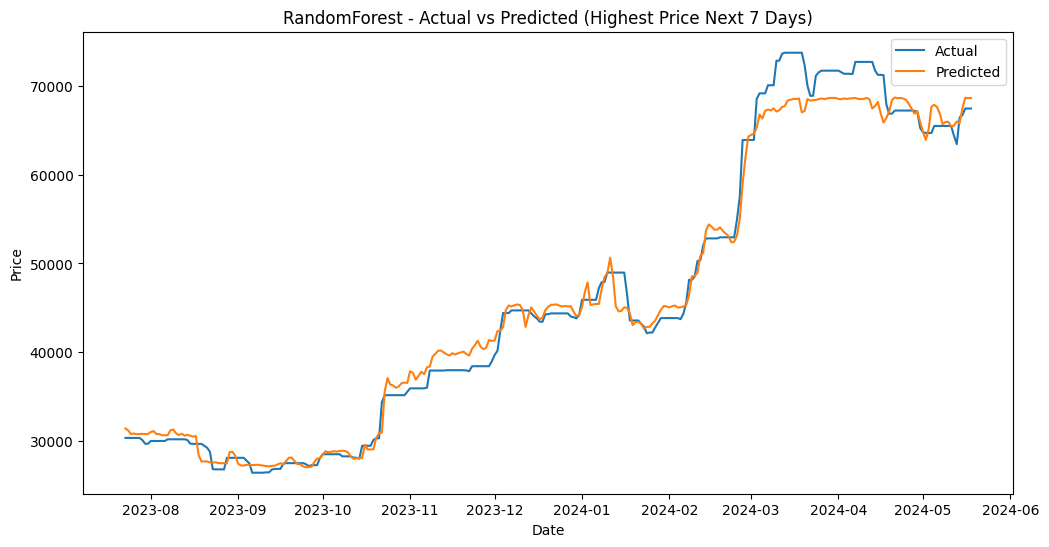


Training LinearRegression model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
LinearRegression - Best Parameters: {}
LinearRegression - Mean Squared Error: 1371722.5269940372
LinearRegression - Mean Absolute Error: 833.2810041747113


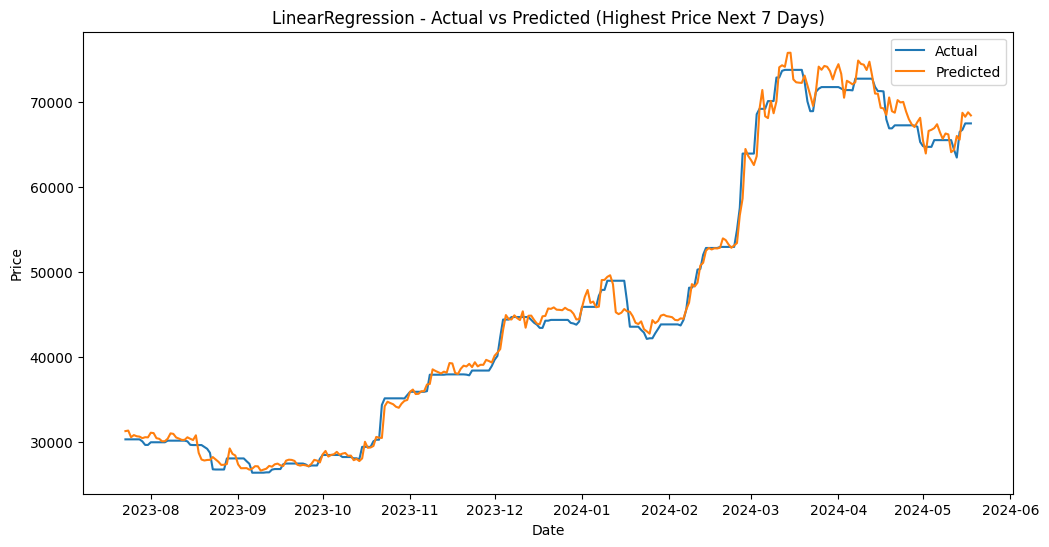


Training SVR model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 192, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1122, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1143, in _check_y
    y = column_or_1d(y, warn=True)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1202, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (252, 3) instead.

--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 192, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1122, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1143, in _check_y
    y = column_or_1d(y, warn=True)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1202, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (503, 3) instead.

--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 192, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1122, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1143, in _check_y
    y = column_or_1d(y, warn=True)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1202, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (754, 3) instead.

--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 192, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1122, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1143, in _check_y
    y = column_or_1d(y, warn=True)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1202, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (1005, 3) instead.

--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 192, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1122, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1143, in _check_y
    y = column_or_1d(y, warn=True)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1202, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (1256, 3) instead.


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1. Data Acquisition and Preprocessing
data = yf.download(tickers='BTC-USD', period='5y')

# Feature Engineering
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['Volatility'] = data['High'] - data['Low']

data['Highest_Next_7'] = data['High'].shift(-1).rolling(window=7).max()
data['Lowest_Next_7'] = data['Low'].shift(-1).rolling(window=7).min()
data['Avg_Close_Next_7'] = data['Close'].shift(-1).rolling(window=7).mean()

# # Get the indices (dates) corresponding to the highest and lowest values
# data['Date_Highest_Next_7'] = data['Highest_Next_7'].rolling(window=7).apply(lambda x: data['Date'][x.index[np.nanargmax(x.values)]])
# data['Date_Lowest_Next_7'] = data['Lowest_Next_7'].rolling(window=7).apply(lambda x: data['Date'][x.index[np.nanargmin(x.values)]])

# Drop rows with NaN values (due to feature calculations and shifts)
data.dropna(inplace=True)

# Split features (X) and target variables (y)
X = data.drop(
    ['Highest_Next_7', 'Lowest_Next_7', 'Avg_Close_Next_7'],
    axis=1
)
y = data[['Highest_Next_7', 'Lowest_Next_7', 'Avg_Close_Next_7']]

# Split into training and testing sets with TimeSeriesSplit for time-series data
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# 2. Model Selection and Training (Multiple Models)

# Initialize models with hyperparameter grids
models = {
    'RandomForest': (RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [4, 5, 6, 7, 8],
        'criterion': ['squared_error', 'absolute_error']
    }),
    'LinearRegression': (LinearRegression(), {}),
    'SVR': (SVR(), {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    })
}

# Train and evaluate each model
for name, (model, param_grid) in models.items():
    print(f"\nTraining {name} model...")
    grid_search = GridSearchCV(model, param_grid, cv=tscv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)  # Train on all target variables at once
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test[['Highest_Next_7', 'Lowest_Next_7', 'Avg_Close_Next_7']], y_pred[:, :3])  # Calculate MSE for only price predictions
    mae = mean_absolute_error(y_test[['Highest_Next_7', 'Lowest_Next_7', 'Avg_Close_Next_7']], y_pred[:, :3])  # Calculate MAE for only price predictions

    print(f"{name} - Best Parameters:", grid_search.best_params_)
    print(f"{name} - Mean Squared Error:", mse)
    print(f"{name} - Mean Absolute Error:", mae)

    # Plot Actual vs Predicted for the first target variable (example)
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test['Highest_Next_7'], label='Actual')
    plt.plot(y_test.index, y_pred[:, 0], label='Predicted')  # Assuming y_pred is a 2D array
    plt.title(f"{name} - Actual vs Predicted (Highest Price Next 7 Days)")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt

# 1. Data Acquisition and Preprocessing
data = yf.download(tickers='BTC-USD', period='5y')

# Feature Engineering
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['Volatility'] = data['High'] - data['Low']

# Create target variables (highest, lowest, average closing, and dates)
# We shift by -1 instead of -7 because .rolling() includes the current day
data['Highest_Next_7'] = data['High'].shift(-1).rolling(window=7).max()
data['Lowest_Next_7'] = data['Low'].shift(-1).rolling(window=7).min()
data['Avg_Close_Next_7'] = data['Close'].shift(-1).rolling(window=7).mean()

# Calculate the relative day number (0 for the first day, 1 for the second, etc.)
first_date = data.index.min()
data['DayNumber'] = (data.index - first_date).days

# Calculate day number of highest and lowest
def get_day_number_of_max(x):
    max_index = (x == x.max()).idxmax()
    return data.loc[max_index, 'DayNumber'] if not x.empty else pd.NaT

def get_day_number_of_min(x):
    min_index = (x == x.min()).idxmin()
    return data.loc[min_index, 'DayNumber'] if not x.empty else pd.NaT

data['DayNumber_Highest_Next_7'] = data['High'].shift(-1).rolling(window=7).apply(get_day_number_of_max)
data['DayNumber_Lowest_Next_7'] = data['Low'].shift(-1).rolling(window=7).apply(get_day_number_of_min)

# Convert day numbers back to datetime for final target variables
data['Date_Highest_Next_7'] = data['DayNumber_Highest_Next_7'].apply(lambda x: first_date + pd.to_timedelta(x, unit='d'))
data['Date_Lowest_Next_7'] = data['DayNumber_Lowest_Next_7'].apply(lambda x: first_date + pd.to_timedelta(x, unit='d'))

# Drop rows with NaN values (due to feature calculations and shifts)
data.dropna(inplace=True)

# Split features (X) and target variables (y)
# Separate price targets and date targets
X = data.drop(
    ['Highest_Next_7', 'Lowest_Next_7', 'Avg_Close_Next_7', 'Date_Highest_Next_7', 'Date_Lowest_Next_7'],
    axis=1
)
y_price = data[['Highest_Next_7', 'Lowest_Next_7', 'Avg_Close_Next_7']]
y_date_high = data['DayNumber_Highest_Next_7']
y_date_low = data['DayNumber_Lowest_Next_7']

# Split into training and testing sets with TimeSeriesSplit for time-series data
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_price_train, y_price_test = y_price.iloc[train_index], y_price.iloc[test_index]
    y_date_high_train, y_date_high_test = y_date_high.iloc[train_index], y_date_high.iloc[test_index]
    y_date_low_train, y_date_low_test = y_date_low.iloc[train_index], y_date_low.iloc[test_index]
# Drop the temporary columns after the split so they are not included in the model
X = X.drop(columns=['DayNumber', 'DayNumber_Highest_Next_7', 'DayNumber_Lowest_Next_7'])
# 2. Model Selection and Training (Separate for Price and Dates)

# Models for price prediction
models_price = {
    'RandomForest': (RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [4, 5, 6, 7, 8],
        'criterion': ['squared_error', 'absolute_error']
    })
}

# Model for date prediction (using a classifier for the day number)
model_date = (RandomForestClassifier(), {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
})

# Train and evaluate price models
for name, (model, param_grid) in models_price.items():
    print(f"\nTraining {name} model for price...")
    grid_search = GridSearchCV(model, param_grid, cv=tscv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_price_train)
    best_model = grid_search.best_estimator_
    y_price_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_price_test, y_price_pred)
    mae = mean_absolute_error(y_price_test, y_price_pred)

    print(f"{name} - Best Parameters:", grid_search.best_params_)
    print(f"{name} - Mean Squared Error:", mse)
    print(f"{name} - Mean Absolute Error:", mae)

    # ... (plotting code remains the same)

# Train and evaluate date model (separately for high and low)
print("\nTraining RandomForest model for date (high)...")
grid_search = GridSearchCV(model_date[0], model_date[1], cv=tscv, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_date_high_train)
best_model_date_high = grid_search.best_estimator_
y_date_high_pred = best_model_date_high.predict(X_test)
accuracy_high = accuracy_score(y_date_high_test, y_date_high_pred)
print("RandomForest - Date (High) - Best Parameters:", grid_search.best_params_)
print("RandomForest - Date (High) - Accuracy:", accuracy_high)


[*********************100%%**********************]  1 of 1 completed



Training RandomForest model for price...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
RandomForest - Best Parameters: {'criterion': 'squared_error', 'max_depth': 8, 'n_estimators': 200}
RandomForest - Mean Squared Error: 3774067.457987463
RandomForest - Mean Absolute Error: 1305.7910409450171

Training RandomForest model for date (high)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
RandomForest - Date (High) - Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 50}
RandomForest - Date (High) - Accuracy: 0.0


In [ ]:
pip install scikeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


[*********************100%%**********************]  1 of 1 completed


Training RandomForest model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits



/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


RandomForest - Best Parameters: {'criterion': 'absolute_error', 'max_depth': 4, 'n_estimators': 100}
RandomForest - Mean Squared Error: 12009737.285254782
RandomForest - Mean Absolute Error: 2424.8997626565592


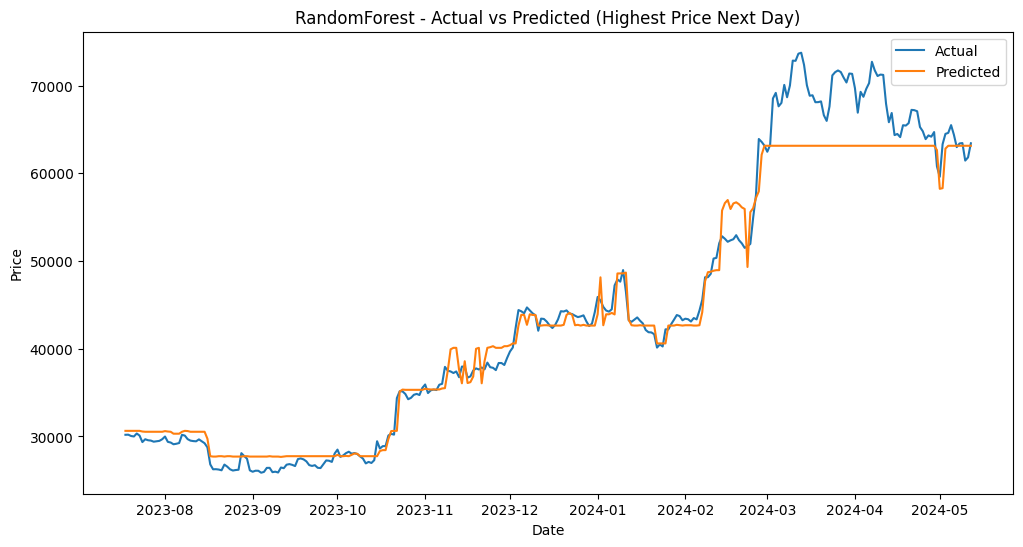

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor  # Import from scikeras
import matplotlib.pyplot as plt

# 1. Data Acquisition and Preprocessing
data = yf.download(tickers='BTC-USD', period='5y')

# Feature Engineering
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['Volatility'] = data['High'] - data['Low']

# Create target variables for the next 7 days
for i in range(1, 8):  # Create targets for days 1 through 7
    data[f'High_Day_{i}'] = data['High'].shift(-i)
    data[f'Low_Day_{i}'] = data['Low'].shift(-i)
    data[f'Close_Day_{i}'] = data['Close'].shift(-i)

# Drop rows with NaN values (due to shifting)
data.dropna(inplace=True)

# Split features (X) and target variables (y)
X = data.drop([f'High_Day_{i}' for i in range(1, 8)] + [f'Low_Day_{i}' for i in range(1, 8)] + [f'Close_Day_{i}' for i in range(1, 8)], axis=1)
y = data[[f'High_Day_{i}' for i in range(1, 8)] + [f'Low_Day_{i}' for i in range(1, 8)] + [f'Close_Day_{i}' for i in range(1, 8)]]

# Split into training and testing sets with TimeSeriesSplit for time-series data
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


# 2. Model Selection and Training (Multiple Models)

def create_mlp_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(21))  # 21 output neurons for 3 targets x 7 days
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
# Initialize models with hyperparameter grids
models = {
    'RandomForest': (RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [4, 5, 6, 7, 8],
        'criterion': ['squared_error', 'absolute_error']
    })
}

# Function to create the MLP model


# Train and evaluate each model
for name, (model, param_grid) in models.items():
    print(f"\nTraining {name} model...")
    grid_search = GridSearchCV(model, param_grid, cv=tscv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)  # Train on all target variables at once
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{name} - Best Parameters:", grid_search.best_params_)
    print(f"{name} - Mean Squared Error:", mse)
    print(f"{name} - Mean Absolute Error:", mae)

    # Plot Actual vs Predicted for the first target variable (example)
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test['High_Day_1'], label='Actual')
    plt.plot(y_test.index, y_pred[:, 0], label='Predicted')
    plt.title(f"{name} - Actual vs Predicted (Highest Price Next Day)")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()



Training MLP model...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model inst

MLP - Best Parameters: {'batch_size': 16, 'epochs': 100}
MLP - Mean Squared Error: 6337561.585893213
MLP - Mean Absolute Error: 1680.2569602554565


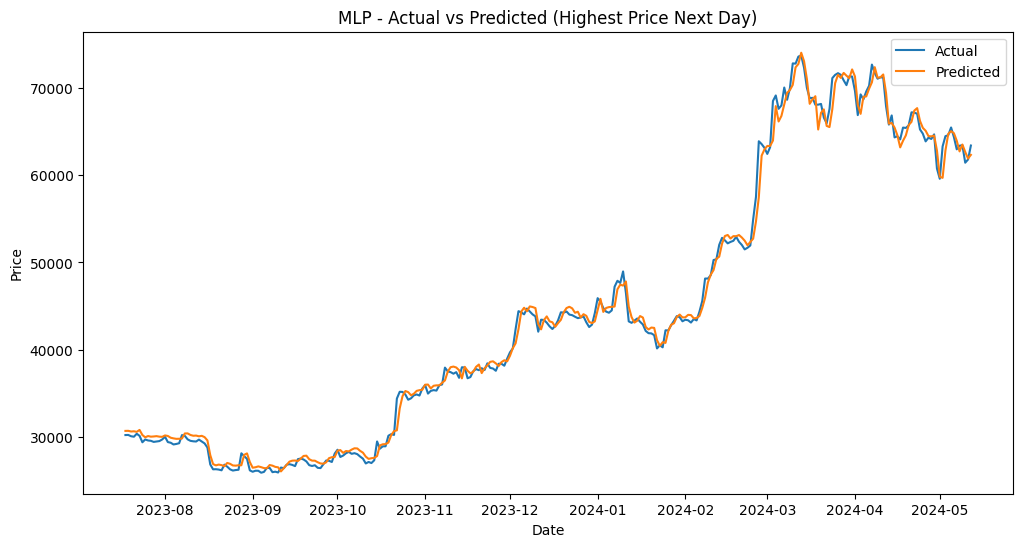

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

# ... (Data Acquisition and Preprocessing remain the same)

# Standardize features (important for some models like SVR and MLP)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Model Selection and Training (Separate for Price and Dates)

# Function to create the MLP model
def create_mlp_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(21))  # 21 output neurons for 3 targets x 7 days
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Initialize models with hyperparameter grids
models = {
    'MLP': (KerasRegressor(build_fn=create_mlp_model, verbose=0), {
        'batch_size': [16, 32],
        'epochs': [50, 100]
    })
}


# Train and evaluate each model
for name, (model, param_grid) in models.items():
    print(f"\nTraining {name} model...")
    grid_search = GridSearchCV(model, param_grid, cv=tscv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)  # Train on all target variables at once
    best_model = grid_search.best_estimator_

    # Make predictions and convert to NumPy array
    y_pred = best_model.predict(X_test)
    y_pred = np.array(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{name} - Best Parameters:", grid_search.best_params_)
    print(f"{name} - Mean Squared Error:", mse)
    print(f"{name} - Mean Absolute Error:", mae)

    # Plot Actual vs Predicted for the first target variable (example)
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.iloc[:,0], label='Actual')
    plt.plot(y_test.index, y_pred[:, 0], label='Predicted')
    plt.title(f"{name} - Actual vs Predicted (Highest Price Next Day)")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [ ]:
y_pred[-1]

array([63139.96285156, 63090.08201172, 63116.23386719, 62954.23519531,
       62642.19289063, 62411.98761719, 62152.14212891, 60364.38011719,
       60378.28796875, 60309.58556641, 60336.09347656, 60154.47146484,
       59910.23023437, 59675.15400391, 61769.430625  , 61735.45878906,
       61741.47865234, 61559.74697266, 61227.86236328, 61026.83392578,
       60758.0059375 ])

In [ ]:
len(y_pred[0])

21

In [ ]:
input_date_str = "2024-05-10"
input_date = pd.Timestamp(input_date_str)
input_row = X.loc[input_date]

# Create a DataFrame for the input data and align columns
X_input = pd.DataFrame([input_row])
X_input = X_input.reindex(columns=X_train.columns, fill_value=0)

# Scale the input features
X_input = scaler.transform(X_input)

# Make predictions for the 7 days following the input date
predictions = best_model.predict(X_input)

prediction_dates = pd.date_range(start=input_date + pd.Timedelta(days=1), periods=7)

# Extract the highest, lowest, and average closing prices over the next 7 days
highest_price = np.max(predictions[0][0::3])  # Get every 3rd element (High_Day)
lowest_price = np.min(predictions[0][1::3])  # Get every 3rd element, starting from the second (Low_Day)
avg_closing_price = np.mean(predictions[0][2::3])  # Get every 3rd element, starting from the third (Close_Day)

# Print the prediction results for the following 7 days
print(f"\nPrediction Results for the Next 7 Days from {input_date_str}:")
print(f"- Highest Price: ${highest_price:.2f}")
print(f"- Lowest Price: ${lowest_price:.2f}")
print(f"- Average Closing Price: ${avg_closing_price:.2f}")


Prediction Results for the Next 7 Days from 2024-05-10:
- Highest Price: $7348.17
- Lowest Price: $7037.07
- Average Closing Price: $7217.92


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
y.head()

,High_Day_1,High_Day_2,High_Day_3,High_Day_4,High_Day_5,High_Day_6,High_Day_7,Low_Day_1,Low_Day_2,Low_Day_3,...,Low_Day_5,Low_Day_6,Low_Day_7,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5,Close_Day_6,Close_Day_7
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-07,8076.891113,7975.974121,8031.909668,8026.394043,8196.648438,8311.567383,8710.636719,7837.610840,7583.219727,7586.730957,...,7862.359863,8087.061035,8183.393066,7954.127930,7688.077148,8000.329590,7927.714355,8145.857422,8230.923828,8693.833008
2019-06-08,7975.974121,8031.909668,8026.394043,8196.648438,8311.567383,8710.636719,8859.127930,7583.219727,7586.730957,7772.803711,...,8087.061035,8183.393066,8618.395508,7688.077148,8000.329590,7927.714355,8145.857422,8230.923828,8693.833008,8838.375000
2019-06-09,8031.909668,8026.394043,8196.648438,8311.567383,8710.636719,8859.127930,9335.867188,7586.730957,7772.803711,7862.359863,...,8183.393066,8618.395508,8814.556641,8000.329590,7927.714355,8145.857422,8230.923828,8693.833008,8838.375000,8994.488281
2019-06-10,8026.394043,8196.648438,8311.567383,8710.636719,8859.127930,9335.867188,9416.407227,7772.803711,7862.359863,8087.061035,...,8618.395508,8814.556641,8988.923828,7927.714355,8145.857422,8230.923828,8693.833008,8838.375000,8994.488281,9320.352539
2019-06-11,8196.648438,8311.567383,8710.636719,8859.127930,9335.867188,9416.407227,9348.374023,7862.359863,8087.061035,8183.393066,...,8814.556641,8988.923828,9004.901367,8145.857422,8230.923828,8693.833008,8838.375000,8994.488281,9320.352539,9081.762695


In [ ]:
data.index

DatetimeIndex(['2019-06-07', '2019-06-08', '2019-06-09', '2019-06-10',
               '2019-06-11', '2019-06-12', '2019-06-13', '2019-06-14',
               '2019-06-15', '2019-06-16',
               ...
               '2024-05-03', '2024-05-04', '2024-05-05', '2024-05-06',
               '2024-05-07', '2024-05-08', '2024-05-09', '2024-05-10',
               '2024-05-11', '2024-05-12'],
              dtype='datetime64[ns]', name='Date', length=1802, freq=None)

**Good Code**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
import warnings


# 1. Data Acquisition and Preprocessing
data = yf.download(tickers='BTC-USD', period='5y')

# Feature Engineering
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['Volatility'] = data['High'] - data['Low']


# Create target variables for the next 7 days BEFORE filling NaNs
for i in range(1, 8):
    data[f'High_Day_{i}'] = data['High'].shift(-i)
    data[f'Low_Day_{i}'] = data['Low'].shift(-i)
    data[f'Close_Day_{i}'] = data['Close'].shift(-i)

# Add day number relative to the start of the dataset as a feature
first_date = data.index.min()
data['DayNumber'] = (data.index - first_date).days


# Fill NaN values in feature and target columns. We dont want to use any values after our cutoff
# so we are going to use limit

# Split features (X) and target variables (y)
X = data.drop([f'High_Day_{i}' for i in range(1, 8)] + [f'Low_Day_{i}' for i in range(1, 8)] + [f'Close_Day_{i}' for i in range(1, 8)], axis=1)
y = data[[f'High_Day_{i}' for i in range(1, 8)] + [f'Low_Day_{i}' for i in range(1, 8)] + [f'Close_Day_{i}' for i in range(1, 8)]]

X.interpolate(method='linear', inplace=True)
y.interpolate(method='linear', inplace=True)


X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)
# Split data into training and testing sets.
# We use the data until the second last row for training
X_train, X_test = X.iloc[:-7], X.iloc[-7:]
y_train, y_test = y.iloc[:-7], y.iloc[-7:]


# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Double-check for NaN values
# if np.isnan(X_train_scaled).any() or np.isnan(y_train).any():
#     warnings.warn("NaNs found in training data after scaling. Please check your data.")
# if np.isnan(X_test_scaled).any() or np.isnan(y_test).any():
#     warnings.warn("NaNs found in testing data after scaling. Please check your data.")

# 2. Model Selection and Training (MLP)
def create_mlp_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(21))  # 21 output neurons for 3 targets x 7 days
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Create and train the MLP model
model = KerasRegressor(build_fn=create_mlp_model, verbose=4)
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)


# 3. Get User Input and Make Predictions (for future dates)
while True:
    input_date_str = input("Enter a date (yyyy-mm-dd) or type 'quit' to exit: ")
    if input_date_str.lower() == 'quit':
        break

    try:
        input_date = pd.Timestamp(input_date_str)
    except ValueError:
        print("Invalid date format. Please use yyyy-mm-dd.")
        continue

    # Check if input date is in the range of data in X
    if not (X.index.min() <= input_date <= X.index.max()):
        print("Date out of valid range for predictions (must be within the dataset).")
        continue
    else:
        # Calculate the relative day number (0 for the first day, 1 for the second, etc.)
        input_day_number = (input_date - first_date).days
        # Get the row corresponding to the input day number
        input_row = X[X['DayNumber'] == input_day_number].iloc[0]

        # Create a DataFrame for the input data and align columns
        X_input = pd.DataFrame([input_row])
        X_input = X_input.reindex(columns=X_train.columns, fill_value=0)

        # Scale the input features
        X_input = scaler.transform(X_input)

        # Make predictions for the 7 days following the input date
        predictions = model.predict(X_input)

        prediction_dates = pd.date_range(start=input_date + pd.Timedelta(days=1), periods=7)

        # Extract the highest, lowest, and average closing prices over the next 7 days
        highest_price = np.max(predictions[0][0::3])  # Get every 3rd element (High_Day)
        lowest_price = np.min(predictions[0][1::3])  # Get every 3rd element, starting from the second (Low_Day)
        avg_closing_price = np.mean(predictions[0][2::3])  # Get every 3rd element, starting from the third (Close_Day)

        # Print the prediction results for the following 7 days
        print(f"\nPrediction Results for the Next 7 Days from {input_date_str}:")
        print(f"- Highest Price: ${highest_price:.2f}")
        print(f"- Lowest Price: ${lowest_price:.2f}")
        print(f"- Average Closing Price: ${avg_closing_price:.2f}")

[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



<ipython-input-25-0191a8c03a91>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.interpolate(method='linear', inplace=True)
<ipython-input-25-0191a8c03a91>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.fillna(y.mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 7

KeyboardInterrupt: Interrupted by user


Training LSTM model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM - Best Parameters: {'model__activation': 'relu', 'model__dropout_rate': 0.1, 'model__optimizer': 'rmsprop'}
LSTM - Mean Squared Error (High): 557370864.3291514
LSTM - Mean Squared Error (Low): 238179281.6960745
LSTM - Mean Squared Error (Close): 385399276.14196426


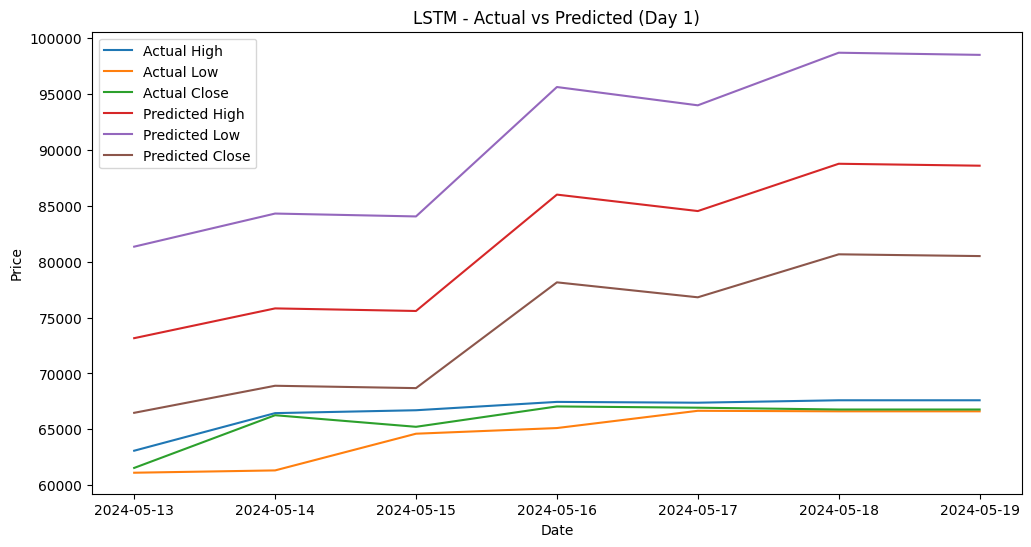


Training RandomForest model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
RandomForest - Best Parameters: {'criterion': 'absolute_error', 'max_depth': 4, 'n_estimators': 200}
RandomForest - Mean Squared Error (High): 2577544.3768274523
RandomForest - Mean Squared Error (Low): 12658895.698928505
RandomForest - Mean Squared Error (Close): 5755452.710995522


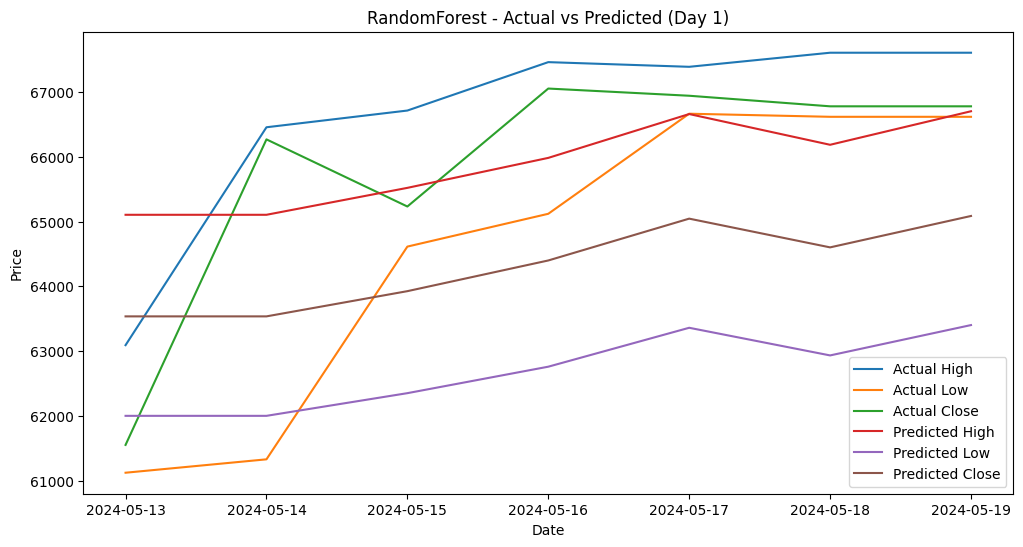


Training MLP model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MLP - Best Parameters: {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__optimizer': 'rmsprop'}
MLP - Mean Squared Error (High): 4538444875.4392
MLP - Mean Squared Error (Low): 4362733427.326033
MLP - Mean Squared Error (Close): 4432669450.37026


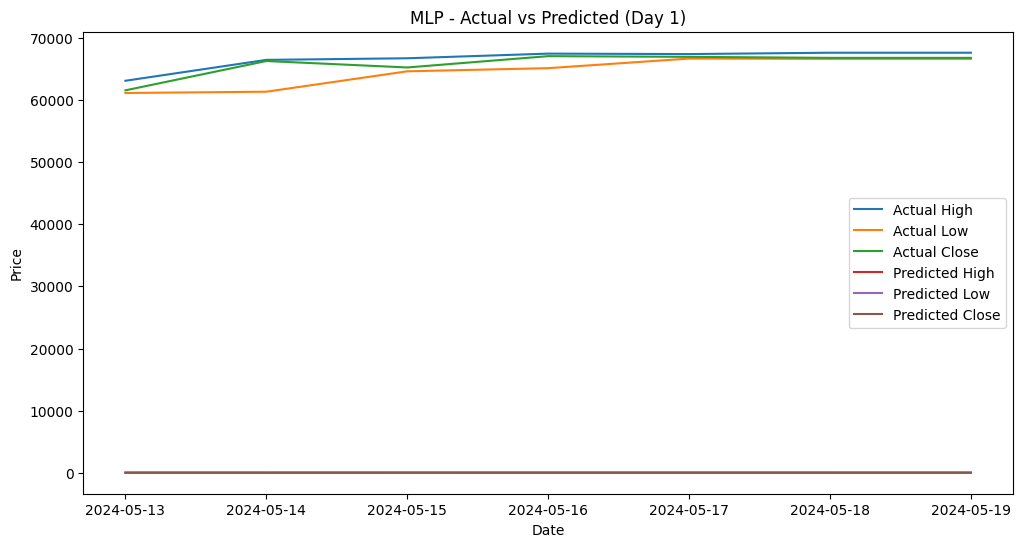

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from scikeras.wrappers import KerasRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
def create_lstm_model(optimizer='adam', activation='relu', dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(64, activation=activation, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation=activation))
    model.add(Dense(21))  # 21 output neurons for 3 targets x 7 days
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def create_mlp_model(optimizer='adam', activation='relu', dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(64, activation=activation, input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation=activation))
    model.add(Dense(21))  # 21 output neurons for 3 targets x 7 days
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
# Define model and hyperparameter grid
def create_lstm_model(optimizer='adam', activation='relu', dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(64, activation=activation, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation=activation))
    model.add(Dense(21))  # 21 output neurons for 3 targets x 7 days
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
# Function to create the MLP model
def create_mlp_model(optimizer='adam', activation='relu', dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(64, activation=activation, input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation=activation))
    model.add(Dense(21))  # 21 output neurons for 3 targets x 7 days
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
# Define model and hyperparameter grid
models = {
    'LSTM': (KerasRegressor(build_fn=create_lstm_model, verbose=0), {
        'model__optimizer': ['adam', 'rmsprop'],
        'model__activation': ['relu', 'tanh'],
        'model__dropout_rate': [0.1, 0.2, 0.3]
    }),
    'RandomForest': (RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [4, 5, 6, 7, 8],
        'criterion': ['squared_error', 'absolute_error']
    }),
    'MLP': (KerasRegressor(build_fn=create_mlp_model, verbose=0), {
        'model__optimizer': ['adam', 'rmsprop'],
        'model__activation': ['relu', 'tanh'],
        'model__dropout_rate': [0.1, 0.2, 0.3]
    }),
}

# Train and evaluate each model with hyperparameter tuning
tscv = TimeSeriesSplit(n_splits=5)
for name, (model, param_grid) in models.items():
    print(f"\nTraining {name} model...")
    grid_search = GridSearchCV(model, param_grid, cv=tscv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1)) if name == 'LSTM' else X_train_scaled, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1)) if name == 'LSTM' else X_test_scaled)
    y_pred = np.array(y_pred)

    # Calculate Mean Squared Errors (MSE) for each day and target
    mse_high = mean_squared_error(y_test[[f'High_Day_{i}' for i in range(1, 8)]], y_pred[:, :7])
    mse_low = mean_squared_error(y_test[[f'Low_Day_{i}' for i in range(1, 8)]], y_pred[:, 7:14])
    mse_close = mean_squared_error(y_test[[f'Close_Day_{i}' for i in range(1, 8)]], y_pred[:, 14:21])

    print(f"{name} - Best Parameters:", grid_search.best_params_)
    print(f"{name} - Mean Squared Error (High):", mse_high)
    print(f"{name} - Mean Squared Error (Low):", mse_low)
    print(f"{name} - Mean Squared Error (Close):", mse_close)

    # Plot Actual vs Predicted for the first day (example)
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test[f'High_Day_1'], label='Actual High')
    plt.plot(y_test.index, y_test[f'Low_Day_1'], label='Actual Low')
    plt.plot(y_test.index, y_test[f'Close_Day_1'], label='Actual Close')
    plt.plot(y_test.index, y_pred[:, 0], label='Predicted High')
    plt.plot(y_test.index, y_pred[:, 7], label='Predicted Low')
    plt.plot(y_test.index, y_pred[:, 14], label='Predicted Close')
    plt.title(f"{name} - Actual vs Predicted (Day 1)")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [ ]:
y_test.head()

,High_Day_1,High_Day_2,High_Day_3,High_Day_4,High_Day_5,High_Day_6,High_Day_7,Low_Day_1,Low_Day_2,Low_Day_3,...,Low_Day_5,Low_Day_6,Low_Day_7,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5,Close_Day_6,Close_Day_7
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-13,63092.125000,66454.453125,66712.429688,67459.460938,67387.328125,67604.679688,67604.679688,61123.765625,61330.410156,64613.054688,...,66663.500000,66615.835938,66615.835938,61552.789062,66267.492188,65231.582031,67051.875000,66940.804688,66777.6875,66777.6875
2024-05-14,66454.453125,66712.429688,67459.460938,67387.328125,67604.679688,67604.679688,67604.679688,61330.410156,64613.054688,65119.316406,...,66615.835938,66615.835938,66615.835938,66267.492188,65231.582031,67051.875000,66940.804688,66777.687500,66777.6875,66777.6875
2024-05-15,66712.429688,67459.460938,67387.328125,67604.679688,67604.679688,67604.679688,67604.679688,64613.054688,65119.316406,66663.500000,...,66615.835938,66615.835938,66615.835938,65231.582031,67051.875000,66940.804688,66777.687500,66777.687500,66777.6875,66777.6875
2024-05-16,67459.460938,67387.328125,67604.679688,67604.679688,67604.679688,67604.679688,67604.679688,65119.316406,66663.500000,66615.835938,...,66615.835938,66615.835938,66615.835938,67051.875000,66940.804688,66777.687500,66777.687500,66777.687500,66777.6875,66777.6875
2024-05-17,67387.328125,67604.679688,67604.679688,67604.679688,67604.679688,67604.679688,67604.679688,66663.500000,66615.835938,66615.835938,...,66615.835938,66615.835938,66615.835938,66940.804688,66777.687500,66777.687500,66777.687500,66777.687500,66777.6875,66777.6875


In [ ]:
y_pred[0]

array([ 9.997664 , 17.035368 ,  6.075796 ,  2.0628016,  7.377503 ,
        9.003535 ,  4.1212773,  3.9210484, 13.319023 ,  9.278823 ,
        6.998893 ,  6.3737535, 13.898711 , 11.523455 ,  9.935076 ,
        7.554735 ,  4.1776366,  8.49556  , 12.267548 ,  7.539553 ,
       13.50708  ], dtype=float32)

In [ ]:
!apt-get install -y libta-lib0-dev
!pip install TA-Lib


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libta-lib0-dev
  Using cached TA-Lib-0.4.28.tar.gz (357 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for TA-Lib: filename=TA_Lib-0.4.28-cp310-cp310-linux_x86_64.whl size=2017538 sha256=3aecb1a6f52820fe4d06546d800eb288baa26a82521c821c43bdb2365efa2547
  Stored in directory: /root/.cache/pip/wheels/66/54/9d/10bfd00931c0c993f373269d350635df520b5064e5290a9d94
Successfully built TA-Lib


In [ ]:
# Enhanced Feature Engineering (Technical Indicators and Time Features)
data['SMA_20'] = talib.SMA(data['Close'], timeperiod=20)
data['EMA_50'] = talib.EMA(data['Close'], timeperiod=50)
data['RSI'] = talib.RSI(data['Close'], timeperiod=14)
data['MACD'], _, _ = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['Volatility'] = data['High'] - data['Low']
data['Volume_Change'] = data['Volume'].pct_change()

# Time Features
data['Day_of_Week'] = data.index.dayofweek
data['Month'] = data.index.month

# Create Target Variables (for multiple days and multiple targets)
prediction_days = 7
target_features = ['High', 'Low', 'Close']

for feature in target_features:
    for i in range(1, prediction_days + 1):
        data[f'{feature}_Day_{i}'] = data[feature].shift(-i)

# Fill Missing Values
data.fillna(method='ffill', inplace=True)

# Drop the last 'prediction_days' rows due to NaN values
data.dropna(inplace=True)

# Split Features (X) and Target Variables (y)
X = data.drop([f'{feature}_Day_{i}' for feature in target_features for i in range(1, prediction_days + 1)], axis=1)
y = data[[f'{feature}_Day_{i}' for feature in target_features for i in range(1, prediction_days + 1)]]

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Model Selection and Training (LSTM)
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # LSTM Model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(len(target_features) * prediction_days))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# 3. Get User Input and Make Predictions (for future dates)
while True:
    input_date_str = input("Enter a date (yyyy-mm-dd) or type 'quit' to exit: ")
    if input_date_str.lower() == 'quit':
        break

    try:
        input_date = pd.Timestamp(input_date_str)
    except ValueError:
        print("Invalid date format. Please use yyyy-mm-dd.")
        continue

    # Check if input date is in the range of data in X
    if not (X.index.min() <= input_date <= X.index.max()):
        print("Date out of valid range for predictions (must be within the dataset).")
        continue
    else:
        # Calculate the relative day number (0 for the first day, 1 for the second, etc.)
        input_day_number = (input_date - first_date).days
        # Get the row corresponding to the input day number
        input_row = X[X['DayNumber'] == input_day_number].iloc[0]

        # Create a DataFrame for the input data and align columns
        X_input = pd.DataFrame([input_row])
        X_input = X_input.reindex(columns=X_train.columns, fill_value=0)

        # Scale the input features
        X_input = scaler.transform(X_input)

        # Make predictions for the 7 days following the input date
        predictions = model.predict(X_input)

        prediction_dates = pd.date_range(start=input_date + pd.Timedelta(days=1), periods=7)

        # Extract the highest, lowest, and average closing prices over the next 7 days
        highest_price = np.max(predictions[0][0:7])  # Get every 3rd element (High_Day)
        lowest_price = np.min(predictions[0][7:14])  # Get every 3rd element, starting from the second (Low_Day)
        avg_closing_price = np.mean(predictions[0][14::21])  # Get every 3rd element, starting from the third (Close_Day)

        # Print the prediction results for the following 7 days
        print(f"\nPrediction Results for the Next 7 Days from {input_date_str}:")
        print(f"- Highest Price: ${highest_price:.2f}")
        print(f"- Lowest Price: ${lowest_price:.2f}")
        print(f"- Average Closing Price: ${avg_closing_price:.2f}")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 99319.5391 - val_loss: 306225.2500
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 93245.4766 - val_loss: 304515.5000
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 95150.8516 - val_loss: 303090.5938
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 92191.5234 - val_loss: 301954.7812
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 90219.0391 - val_loss: 300918.7500
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 93606.8984 - val_loss: 299932.0000
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 90338.9297 - val_loss: 298986.5000
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 94366.8516 - val_loss: 298064.3125
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 90821.5156 - val_loss: 297164.9688
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 87610.9609 - val_loss: 296281.4062
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 691974.3125 - val_loss: 77806424.0000
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 612310.3750 - val_loss: 77769208.0000
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 654441.5625 - val_loss: 77741368.0000
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 621807.6875 - val_loss: 77716032.0000
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 684671.5000 - val_loss: 77691560.0000
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 718288.6250 - val_loss: 77667696.0000
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 650159.8125 - val_loss: 77644808.0000
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 620900.4375 - val_loss: 77621432.0000
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 670378.6875 - val_loss: 77598664.0000
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 670743.6250 - val_loss: 77575888.0000
Epoch 11/100
29/29 ━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 25275222.0000 - val_loss: 50316460.0000
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21203566.0000 - val_loss: 50278524.0000
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 24408624.0000 - val_loss: 50245512.0000
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21921148.0000 - val_loss: 50214884.0000
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21590268.0000 - val_loss: 50185024.0000
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21289598.0000 - val_loss: 50155712.0000
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 23877618.0000 - val_loss: 50126388.0000
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 23366230.0000 - val_loss: 50097552.0000
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 21944816.0000 - val_loss: 50069640.0000
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 25203998.0000 - val_loss: 50040884.0000
Epoch 11/10

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 31281116.0000 - val_loss: 566568960.0000
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 30047522.0000 - val_loss: 566513792.0000
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 28005168.0000 - val_loss: 566463616.0000
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 30587624.0000 - val_loss: 566415360.0000
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 29833148.0000 - val_loss: 566367424.0000
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 29833278.0000 - val_loss: 566319360.0000
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 31595836.0000 - val_loss: 566271744.0000
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 31877256.0000 - val_loss: 566224448.0000
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 30777022.0000 - val_loss: 566177600.0000
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 33369486.0000 - val_loss: 566131008.0000
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 136478304.0000 - val_loss: 1671638016.0000
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 146950576.0000 - val_loss: 1671298304.0000
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 137760688.0000 - val_loss: 1670994176.0000
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 122793144.0000 - val_loss: 1670696960.0000
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 117190256.0000 - val_loss: 1670407936.0000
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 132712064.0000 - val_loss: 1670121856.0000
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 130150144.0000 - val_loss: 1669839872.0000
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 134841136.0000 - val_loss: 1669560192.0000
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 132650304.0000 - val_loss: 1669277696.0000
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 124712568.00

KeyboardInterrupt: 

In [ ]:
!pip install scikeras


In [ ]:
# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import talib
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasRegressor

# Function to Create MLP Model
def create_mlp_model(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, batch_size=32, learning_rate='constant'):
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0], input_dim=X.shape[1], activation=activation))
    for size in hidden_layer_sizes[1:]:
        model.add(Dense(size, activation=activation))
    model.add(Dense(len(target_features) * prediction_days))
    model.compile(loss='mean_squared_error', optimizer=solver)
    return model

# 1. Data Acquisition and Preprocessing
data = yf.download(tickers='BTC-USD', period='10y')
# ... (Feature Engineering - same as before) ...
data['SMA_20'] = talib.SMA(data['Close'], timeperiod=20)
data['EMA_50'] = talib.EMA(data['Close'], timeperiod=50)
data['RSI'] = talib.RSI(data['Close'], timeperiod=14)
data['MACD'], _, _ = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['Volatility'] = data['High'] - data['Low']
data['Volume_Change'] = data['Volume'].pct_change()

# Time Features
data['Day_of_Week'] = data.index.dayofweek
data['Month'] = data.index.month

# Create Target Variables (for multiple days and multiple targets)
prediction_days = 7
target_features = ['High', 'Low', 'Close']

for feature in target_features:
    for i in range(1, prediction_days + 1):
        data[f'{feature}_Day_{i}'] = data[feature].shift(-i)

# Fill Missing Values
data.fillna(method='ffill', inplace=True)

# Drop the last 'prediction_days' rows due to NaN values
data.dropna(inplace=True)

# Split Features (X) and Target Variables (y)
X = data.drop([f'{feature}_Day_{i}' for feature in target_features for i in range(1, prediction_days + 1)], axis=1)
y = data[[f'{feature}_Day_{i}' for feature in target_features for i in range(1, prediction_days + 1)]]

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Model Selection and Training (LSTM)
tscv = TimeSeriesSplit(n_splits=5)
# 2. Model Selection, Training, and Ensemble
tscv = TimeSeriesSplit(n_splits=5)

# Create Pipelines for Random Forest and MLP
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KerasRegressor(build_fn=create_mlp_model, verbose=0, epochs=100))
])

# Hyperparameter Grids for Grid Search
param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
}

param_grid_mlp = {
    'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'model__model__activation': ['relu', 'tanh'],
    'model__model__solver': ['adam', 'sgd'],
    'model__model__alpha': [0.0001, 0.001, 0.01],
    'model__batch_size': [16, 32],
    'model__epochs': [50, 100],
}
# Grid Search for Random Forest
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=tscv, scoring='neg_mean_squared_error')
grid_search_rf.fit(X, y)
best_rf_model = grid_search_rf.best_estimator_

# Grid Search for MLP
grid_search_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp, cv=tscv, scoring='neg_mean_squared_error')
grid_search_mlp.fit(X, y)
best_mlp_model = grid_search_mlp.best_estimator_

# Print Best Models and Their Parameters
print("Best Random Forest Model:")
print(best_rf_model)
print("\nBest MLP Model:")
print(best_mlp_model)


# 3. Make Predictions (for future dates) and Ensemble
def ensemble_predict(models, X_input):
    predictions = [model.predict(X_input) for model in models]
    return np.mean(predictions, axis=0)

# User Input Handling
while True:
    input_date_str = input("Enter a date (yyyy-mm-dd) or type 'quit' to exit: ")
    if input_date_str.lower() == 'quit':
        break

    try:
        input_date = pd.Timestamp(input_date_str)

        if not (data.index.min() <= input_date <= data.index.max() - pd.to_timedelta(f"{prediction_days} days")):
            raise ValueError("Date out of valid range.")

        # Prepare input data for the given date
        input_data = data.loc[input_date].drop(y.columns).values.reshape(1, -1)

        # Ensemble Prediction
        ensemble_predictions = ensemble_predict([best_rf_model, best_mlp_model], input_data)

        # Print Prediction Results
        print(f"\nEnsemble Prediction Results for the Next 7 Days from {input_date_str}:")
        for i, feature in enumerate(target_features):
            print(f"- {feature}:")
            for j in range(prediction_days):
                print(f"  Day {j+1}: {ensemble_predictions[i * prediction_days + j]:.2f}")

    except ValueError as e:
        print(f"Error: {e}")


[*********************100%%**********************]  1 of 1 completed


ValueError: Invalid parameter hidden_layer_sizes for estimator KerasRegressor.
This issue can likely be resolved by setting this parameter in the KerasRegressor constructor:
`KerasRegressor(hidden_layer_sizes=(50,))`
Check the list of available parameters with `estimator.get_params().keys()`

In [ ]:
def swing_trading_strategy(open_price, high_prices, low_prices, closing_price_7th_day):
    # Initial conditions: starting with $100,000 worth of bitcoins
    initial_bitcoins = 100000 / open_price

    # Convert price lists to numpy arrays for easier manipulation
    import numpy as np
    highs = np.array(high_prices)
    lows = np.array(low_prices)

    # Initialize variables to track the best strategy
    best_final_value = initial_bitcoins * closing_price_7th_day  # if no selling occurs
    sell_day = None
    load_day = None

    # Iterate over possible sell days (0 to 6)
    for i in range(7):
        # Calculate cash if sold on day i at the high price
        sell_cash = initial_bitcoins * highs[i]

        # Option 1: Do not load, hold cash until the end of the 7th day
        if sell_cash > best_final_value:
            best_final_value = sell_cash
            sell_day = i
            load_day = None

        # Iterate over possible load days (i+1 to 6)
        for j in range(i + 1, 7):
            # Calculate bitcoins if loaded on day j at the low price
            load_bitcoins = sell_cash / lows[j]

            # Calculate the final value in bitcoins on the 7th day
            final_value = load_bitcoins * closing_price_7th_day

            # Check if this strategy is better than the current best
            if final_value > best_final_value:
                best_final_value = final_value
                sell_day = i
                load_day = j

    return {
        'sell_day': sell_day,
        'load_day': load_day,
        'final_value': best_final_value
    }

# Example usage
open_price = 63750.99  # Example open price on the given date
high_prices = [63898.36, 64789.66, 65275.21, 67075.37, 67199.24, 67233.96, 65723.24]  # Example highs for the next 7 days
low_prices = [62424.72, 63322.40, 62783.63, 63589.87, 65864.87, 64548.18, 64277.72]   # Example lows for the next 7 days
closing_price_7th_day = 64926.64  # Example closing price on the 7th day

strategy = swing_trading_strategy(open_price, high_prices, low_prices, closing_price_7th_day)
print(strategy)


{'sell_day': 5, 'load_day': 6, 'final_value': 106528.11025783354}
